## Dependencies

In [1]:
import sys
sys.path.append('/home/maxim/VisibleSpeech/runtime_speech_recognition/data')
sys.path.append('/home/maxim/VisibleSpeech/runtime_speech_recognition')

In [2]:
import torch
from torch import nn

import pytorch_lightning as pl

import torchaudio.transforms as T

from IPython.display import Audio, display
from data import datasets
from utils.utils import provide_reproducibility

## CUDA device

In [3]:
provide_reproducibility(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Datasets

In [4]:
dir_name = '/media/maxim/Programming/voice_datasets/timit/TIMIT_2/data'  # ubuntu

In [5]:
import importlib

importlib.reload(datasets)

vowel_labels = [
    'IY', 'IH', 'EH', 'EY', 'AE', 'AA', 'AW', 'AY',
    'AH', 'AO', 'OY', 'OW', 'UH', 'UW', 'UX', 'ER',
    'AX','IX', 'AXR', 'AH-H'
    ]
consonant_labels = [
        'B', 'D', 'G', 'P', 'T', 'K', 'DX', 'Q',     # stops
        'M', 'N', 'NG', 'EM', 'EN', 'ENG', 'NX',     # nasals
        'JH', 'CH',                                  # affricates
        'S', 'SH', 'Z', 'ZH', 'F', 'TH', 'V', 'DH',  # fricatives
        'L', 'R', 'W', 'Y', 'HH', 'HV', 'EL'         # semivowels_glides
    ]

other_labels = ['H#', 'PAU', 'EPI']

phoneme_classes = {
    'vowels': vowel_labels,
    'consonants': consonant_labels,
    'other': other_labels
}
phone_labels = vowel_labels + consonant_labels + other_labels

timit_dataset_train = datasets.TIMITDataset(
    usage='train',
    percentage=0.05,
    root_dir=dir_name,
    phone_codes=phoneme_classes,
    padding=16000,
    phoneme_labeler=datasets.PhonemeLabeler(phoneme_classes, '.'),
    description_file_path='../data/timit_description.csv'
    )

timit_dataset_test = datasets.TIMITDataset(
    usage='test',
    percentage=0.05,
    root_dir=dir_name,
    phone_codes=phoneme_classes,
    padding=16000,
    phoneme_labeler=datasets.PhonemeLabeler(phoneme_classes, '.'),
    description_file_path='../data/timit_description.csv'
    )

timit_framerate = timit_dataset_train[0].frame_rate

In [6]:
datasets.PhonemeLabeler(phoneme_classes, '.')['K']

'consonants'

In [7]:
timit_dataset_train[0]

AudioData(data=tensor([[ 0.0000e+00,  3.0518e-05, -3.0518e-05,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]]), label='consonants', frame_rate=16000, sample_width=16)

In [8]:
timit_dataset_train.description_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7637 entries, 79269 to 183386
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   phone_name      7637 non-null   object 
 1   phone_class     7637 non-null   object 
 2   usage           7637 non-null   object 
 3   speaker_id      7637 non-null   object 
 4   speaker_gender  7637 non-null   object 
 5   dialect         7637 non-null   object 
 6   wav_file_path   7637 non-null   object 
 7   t0              7637 non-null   float64
 8   t1              7637 non-null   float64
dtypes: float64(2), object(7)
memory usage: 596.6+ KB


<Axes: ylabel='phone_class'>

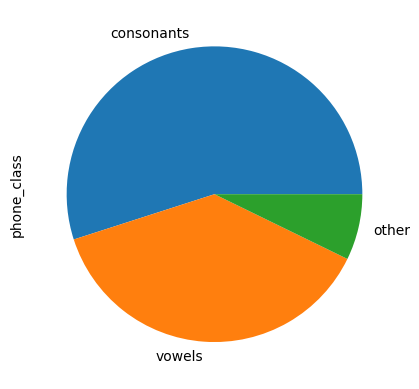

In [9]:
timit_dataset_train.description_table.phone_class.value_counts(normalize=True).plot(kind='pie')

<Axes: ylabel='phone_name'>

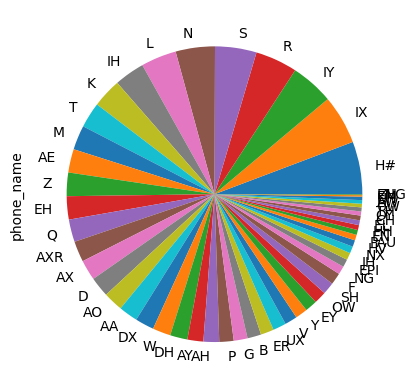

In [10]:
timit_dataset_train.description_table.phone_name.value_counts(normalize=True).plot(kind='pie')

In [11]:
labels = ['consonants', 'vowels', 'other']
num_of_classes = len(labels)

In [12]:
import numpy as np

lengths = list()
for audio_data in timit_dataset_train:
    lengths.append(len(audio_data.data[0]))

lengths_test = list()
for audio_data in timit_dataset_test:
    lengths_test.append(len(audio_data.data[0]))

lengths = np.array(lengths)
lengths_test = np.array(lengths_test)


## Transform

In [13]:
transform = T.Resample(orig_freq=timit_framerate, new_freq=8000)
transform_cpu = T.Resample(orig_freq=timit_framerate, new_freq=8000)

chunk_size = 1024

## Dataloaders

In [14]:
# def label_to_index(phone):
#     index = labels.index(phone)
#     num_labels = len(labels)
#     one_hot = [0] * num_labels
#     one_hot[index] = 1
#     return torch.tensor(one_hot)

def label_to_index(phone):
    # Return the position of the word in labels
    return torch.tensor(labels.index(phone))

def index_to_label(index):
    return labels[index]


def pad_sequence(batch):
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):
    tensors, targets = [], []

    for waveform, label, *_ in batch:
        tensors += [waveform[..., :chunk_size]]
        targets += [label_to_index(label)]

    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 12
    pin_memory = True
else:
    num_workers = 12
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    timit_dataset_train,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    timit_dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

train_features, train_labels = next(iter(train_loader))

In [15]:
train_features[0].shape, train_labels.shape

(torch.Size([1, 1024]), torch.Size([256]))

## Model training

In [16]:
import models
from models import phoneme_recognizer
from models import mixins

importlib.reload(models)
importlib.reload(phoneme_recognizer)
importlib.reload(mixins)

<module 'models.mixins' from '/home/maxim/VisibleSpeech/runtime_speech_recognition/models/mixins.py'>

In [18]:
import torch.nn.functional as F


class M3(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=4, kernel_size=80, n_channel=256):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=kernel_size, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        #
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)

        self.fc1 = nn.Linear(n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)

        x = F.avg_pool1d(x, int(x.shape[-1])) # fixme ????
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)
        # return self.sigmoid(x)

In [19]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=4, n_channel=128):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)

In [20]:
from pathlib import Path

# model params
n_input = 1
n_output = num_of_classes
stride = 4
kernel_size = 80
n_channel = 256
optimizer = 'adadelta'
lr = 3e-2

model_name = 'M3 with other'
# experiment_name = f'no resample, chunk_size={chunk_size}, kernel={kernel_size}, stride={stride}, n_channels={n_channel}, optimizer={optimizer}, lr={lr}'
experiment_name = 'TEST_2023'
project_name = 'Vowel&Consonants'

model_path = Path(f'/home/maxim/VisibleSpeech/PhonemeRecognizer/models/{model_name}')
experiment_path_model = model_path / experiment_name

logs_path = experiment_path_model / 'logs'
cp_path = experiment_path_model / 'cp'
logs_path.mkdir(parents=True, exist_ok=True)
cp_path.mkdir(parents=True, exist_ok=True)

In [21]:
from pathlib import Path
from models.phoneme_recognizer import PhonemeRecognizer, AudioPreprocessorCallback
from pytorch_lightning.callbacks import ModelCheckpoint


model = PhonemeRecognizer(
    acoustic_model=M3,
    num_of_classes=num_of_classes,
    model_params=dict(
        n_input=n_input,
        n_output=num_of_classes,
        stride=stride,
        # kernel_size=kernel_size,
        n_channel=n_channel
    ),
    loss_criterion=nn.NLLLoss(),
    lr=lr,
    target_type=None
)
config_params = dict(
    n_input=n_input,
    n_output=num_of_classes,
    stride=stride,
    n_channel=n_channel,
    optimizer=optimizer,
    lr=lr
)

model_checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath=cp_path,
    filename=model_name + '_' + experiment_name + '{epoch:02d}-{val_loss:.2f}',
    save_top_k=-1,
    mode='min'
)
preprocessor_callback = AudioPreprocessorCallback(transform=transform, device=device)
callbacks = [model_checkpoint_callback]

In [22]:
from pytorch_lightning.loggers import WandbLogger

n_epochs = 10

logger = WandbLogger(
    project=project_name,
    name=f'{model_name}:{experiment_name}',
    save_dir=logs_path,
    log_model='all'
)

trainer = pl.Trainer(
    logger=logger,
    default_root_dir=logs_path,
    accelerator='gpu',
    devices=1,
    # callbacks=callbacks,
    max_epochs=n_epochs,
    log_every_n_steps=10)

logger.watch(model, log='all', log_graph=True)
trainer.fit(model, train_loader, test_loader)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: crazy_historian. Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type             | Params
--------------------------------------------------------
0 | loss_criterion     | NLLLoss          | 0     
1 | train_metrics      | MetricCollection | 0     
2 | val_metrics        | MetricCollection | 0     
3 | test_metrics       | MetricCollection | 0     
4 | checkpoint_metrics | MetricCollection | 0     
5 | acoustic_model     | M3               | 219 K 
--------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.878     Total estimated model params size (MB)


Epoch 2:  73%|███████▎  | 30/41 [00:01<00:00, 23.48it/s, loss=0.624, v_num=6nmr]

Exception ignored in: <function _releaseLock at 0x7fdf55d37eb0>
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 228, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


Epoch 7:  73%|███████▎  | 30/41 [00:01<00:00, 23.00it/s, loss=0.534, v_num=6nmr]

In [14]:
filepath = f'{model_name}_{experiment_name}'
input_sample = train_features[0].unsqueeze(0)

model.to_onnx(filepath, input_sample, export_params=True)

/tmp/ipykernel_26003/4009670632.py:25: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  x = F.avg_pool1d(x, int(x.shape[-1])) # fixme ????
